In [1]:
from flamekit.autoencoder import Decoder, AutoEncoder, Encoder
from flamekit.GLV_autoencoder import SNMLP, MLP, LinearCombo, SNLinearCombo
from flamekit.io_fronts import load_fronts, Case
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import umap
from sklearn.manifold import SpectralEmbedding, TSNE, MDS
from pathlib import Path
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F

import hdbscan


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU


In [3]:
from flamekit.io_fields import field_path
from flamekit.io_fronts import Case
# ============================================================
# CURRENT I/O: MULTI TIMESTEP + MULTI ISOTHERM -> df_all
# ============================================================
def load_fronts_multi_timesteps(
    base_dir: Path,
    phi: float,
    lat_size: str,
    timesteps: list[int],
    isolevels: list[float],
    post: bool = True,
    max_points_per_iso_per_ts: int | None = None,
    seed: int = 0,
) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    frames = []

    for ts in timesteps:
        case = Case(
            base_dir=base_dir,
            phi=phi,
            lat_size=lat_size,
            time_step=ts,
            post=post,
        )

        data_ts = load_fronts(case, isolevels)  # dict[iso] -> DataFrame

        for iso in isolevels:
            df = data_ts[iso].copy()
            df["timestep"] = int(ts)
            df["isotherm"] = float(iso)

            if max_points_per_iso_per_ts is not None and len(df) > max_points_per_iso_per_ts:
                idx = rng.choice(df.index.to_numpy(), size=max_points_per_iso_per_ts, replace=False)
                df = df.loc[idx]

            frames.append(df)

    if not frames:
        raise ValueError("No data loaded. Check timesteps/isolevels and file availability.")

    return pd.concat(frames, ignore_index=True)


## Read data

In [6]:
# ============================================================
# USER SETTINGS
# ============================================================
BASE_DIR = Path("../data/isocontours")
PHI = 0.40
LAT_SIZE = "100"
POST = True

ISOLEVELS = [ 4, 4.5]
TIMESTEPS = [210, 200, 190, 180]
MAX_POINTS_PER_ISO_PER_TS = 80_000

FEATURES = ["stretch_rate", "curvature", "DW_FDS"]


# ============================================================
# READ DATA (ADAPTED): build X from df_all instead of CSV
# ============================================================
df_all = load_fronts_multi_timesteps(
    base_dir=BASE_DIR,
    phi=PHI,
    lat_size=LAT_SIZE,
    timesteps=TIMESTEPS,
    isolevels=ISOLEVELS,
    post=POST,
    max_points_per_iso_per_ts=MAX_POINTS_PER_ISO_PER_TS,
    seed=0,
)

missing = [c for c in FEATURES if c not in df_all.columns]
if missing:
    raise KeyError(f"Missing required columns in loaded fronts: {missing}")

df = df_all[FEATURES].replace([np.inf, -np.inf], np.nan).dropna().copy()
print("Loaded rows:", len(df))
print("Columns:", df.columns.tolist())

X = StandardScaler().fit_transform(df.to_numpy())


Loaded rows: 50446
Columns: ['stretch_rate', 'curvature', 'DW_FDS']


## Autoencoder

In [7]:
num_points, D_orig = X.shape
num_latent = 5
num_hidden = 40

model = AutoEncoder(D_orig, num_latent, num_hidden).to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {num_params:,} (~{num_params*4/1e6:.2f} MB)")

optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-2
)
criterion = nn.MSELoss()

Parameters: 2,168 (~0.01 MB)


In [8]:
# Dataset & Loader
from torch.utils.data import DataLoader, TensorDataset
X_torch = torch.from_numpy(X).float()
dataset = TensorDataset(X_torch)
loader = DataLoader(dataset, batch_size=1024, shuffle=True)

# Training loop
epochs = 10_000

from torch import amp
torch.backends.cudnn.benchmark = True

scaler = amp.GradScaler("cuda")

for epoch in range(epochs):
    running_loss = 0.0
    for (batch,) in loader:
        batch = batch.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        with amp.autocast("cuda"):                # new API
            decoded, encoded = model(batch)
            loss = criterion(decoded, batch)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * batch.size(0)

    epoch_loss = running_loss / len(dataset)
    if epoch % 500 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.6f}")


Epoch [1/10000] - Loss: 0.919174


KeyboardInterrupt: 

In [6]:
X_torch_gpu = X_torch.to(device)
decoded, encoded = model(X_torch_gpu)

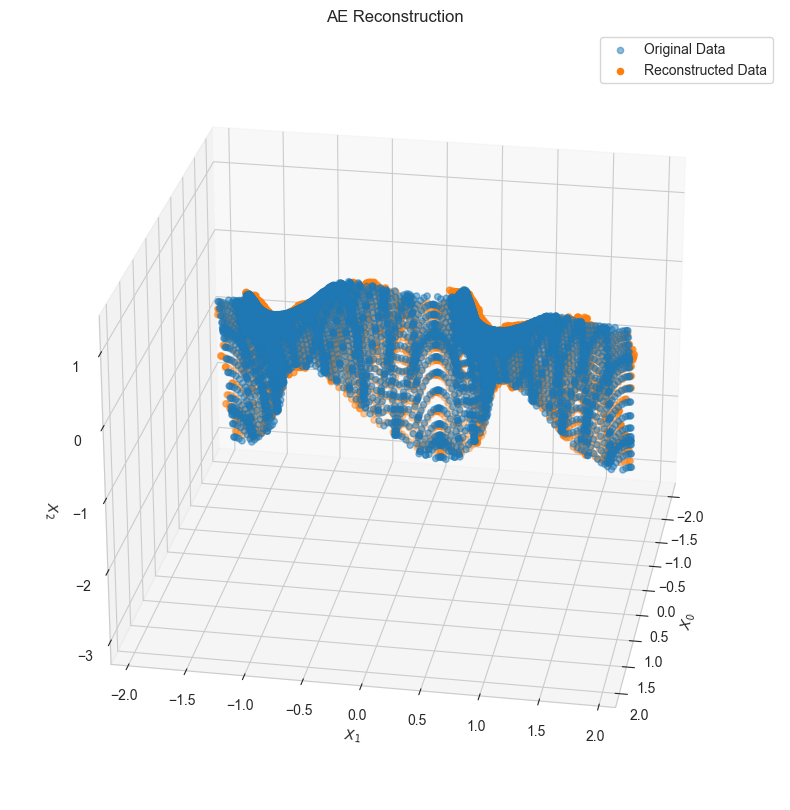

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
X_P = decoded.detach().cpu().numpy()

ax.scatter(X[:,0], X[:,1], X[:,2],alpha=0.5)
ax.scatter(X_P[:,0], X_P[:,1], X_P[:,2])
ax.set_xlabel('$X_0$')
ax.set_ylabel('$X_1$')
ax.set_zlabel('$X_2$')
ax.elev=25
ax.azim=10
plt.legend(['Original Data','Reconstructed Data'])
plt.title("AE Reconstruction")
plt.show()

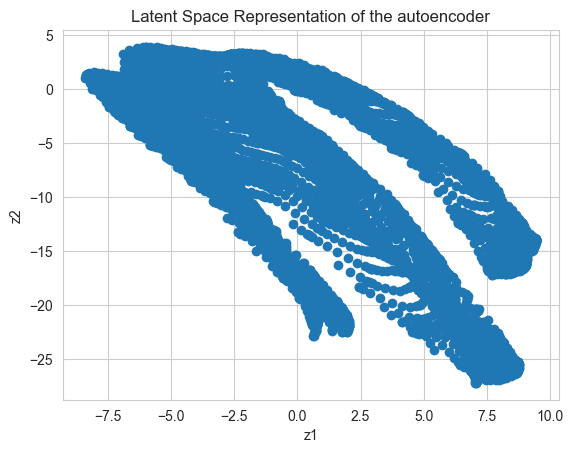

In [8]:
Z = encoded.cpu().detach().numpy()
# Only works if num_latent >=2
if num_latent>=2:
    plt.figure()
    plt.scatter(Z[:,0],Z[:,1])
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Latent Space Representation of the autoencoder')
    plt.show()

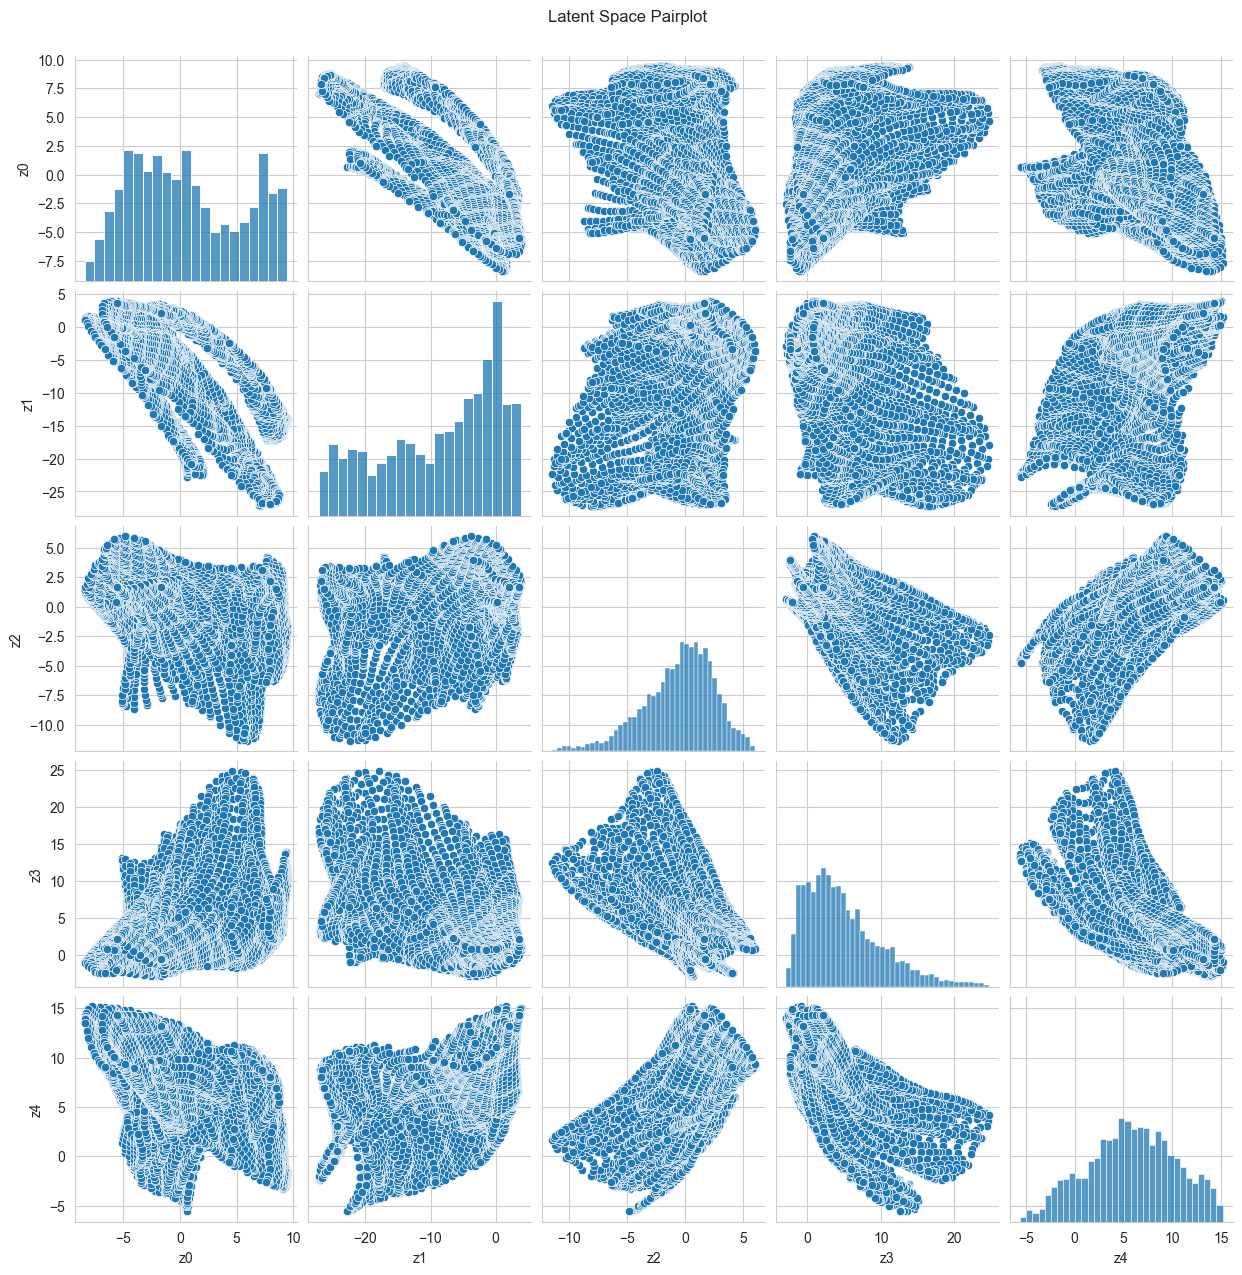

In [9]:
df_latent = pd.DataFrame(Z, columns=[f'z{i}' for i in range(Z.shape[1])])
sns.pairplot(df_latent)
plt.suptitle('Latent Space Pairplot', y=1.02)
plt.show()

## Least Volume Regularization - No Dynamic Pruning(DP)

In [10]:
#| code-fold: false
ambient_dim = X.shape[1]

# Change the below latent dimension to see what happens to the embedded points
latent_dim = 15

width = ambient_dim * 16
encoder = MLP(ambient_dim, latent_dim, [width] * 4)
decoder = MLP(latent_dim, ambient_dim, [width] * 4)

opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)

#| code-fold: false
# Set X to a torch tensor:
X_torch = torch.from_numpy(X).float()

for i in range(5000):
    opt.zero_grad()
    z = encoder(X_torch)
    rec_loss = F.mse_loss(decoder(z), X_torch)
    loss = rec_loss
    # If you want, you can even add an L1 penalty on the latent space
    # to try to encourage sparsity by uncommenting the line below:
    #loss += 1e-3 * torch.mean(torch.abs(z))

    loss.backward()
    opt.step()
    if (i+1) % 100 == 0:
        print(f'Epoch {i:4}: rec = {rec_loss:.5g}')

Epoch   99: rec = 0.18691
Epoch  199: rec = 0.04404
Epoch  299: rec = 0.035124
Epoch  399: rec = 0.010921
Epoch  499: rec = 0.001627
Epoch  599: rec = 0.00068488
Epoch  699: rec = 0.00037145
Epoch  799: rec = 0.00030314
Epoch  899: rec = 0.00018191
Epoch  999: rec = 0.00019926
Epoch 1099: rec = 0.00012567
Epoch 1199: rec = 0.00035379
Epoch 1299: rec = 8.6416e-05
Epoch 1399: rec = 7.6376e-05
Epoch 1499: rec = 7.4893e-05
Epoch 1599: rec = 0.00064956
Epoch 1699: rec = 6.7638e-05
Epoch 1799: rec = 0.00023255
Epoch 1899: rec = 4.8691e-05
Epoch 1999: rec = 4.6036e-05
Epoch 2099: rec = 4.3431e-05
Epoch 2199: rec = 4.6864e-05
Epoch 2299: rec = 4.6523e-05
Epoch 2399: rec = 0.00033694
Epoch 2499: rec = 3.5615e-05
Epoch 2599: rec = 9.7141e-05
Epoch 2699: rec = 3.488e-05
Epoch 2799: rec = 3.032e-05
Epoch 2899: rec = 3.4743e-05
Epoch 2999: rec = 3.9938e-05
Epoch 3099: rec = 2.8473e-05
Epoch 3199: rec = 2.6014e-05
Epoch 3299: rec = 2.6184e-05
Epoch 3399: rec = 3.9894e-05
Epoch 3499: rec = 0.00021595

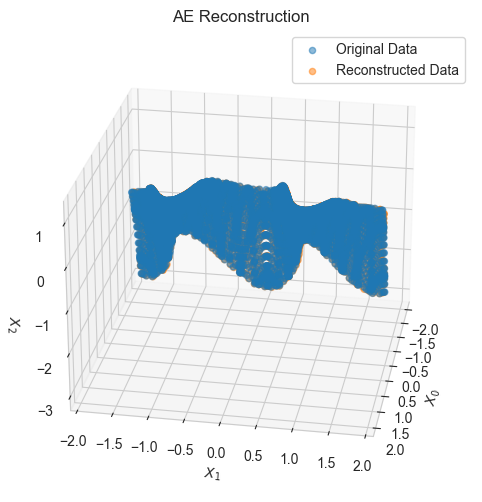

In [11]:
encoder.eval()
decoder.eval()

# Embed the data into Z using the trained encoder
with torch.no_grad():
    z = encoder(X_torch)
    X_P = decoder(encoder(X_torch)).detach().numpy()
# Now let's sort the latent codes by which ones have the
# largest standard deviation in Z:

import matplotlib.pyplot as plt


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], alpha=0.5, label='Original Data')
ax.scatter(X_P[:, 0], X_P[:, 1], X_P[:, 2], alpha=0.5, label='Reconstructed Data')

ax.set_xlabel('$X_0$')
ax.set_ylabel('$X_1$')
ax.set_zlabel('$X_2$')
ax.view_init(elev=25, azim=10)
ax.legend()
plt.title("AE Reconstruction")
plt.show()


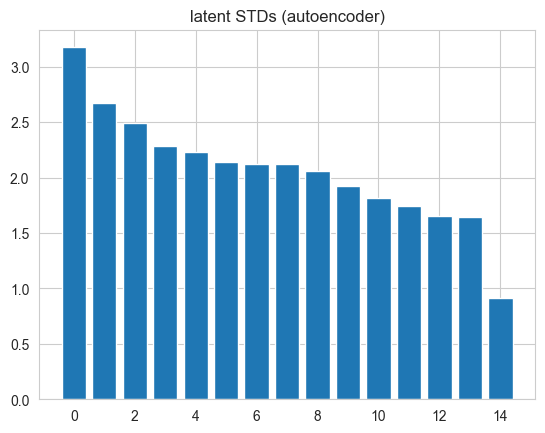

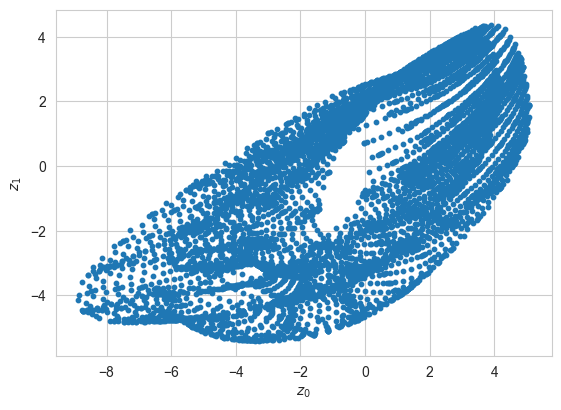

In [12]:
idx = z.std(0).argsort(descending=True)

plt.figure()
plt.bar(np.arange(z.std(0).size(-1)), z.std(0)[idx])
plt.title('latent STDs (autoencoder)')
plt.show()

plt.figure()
plt.scatter(z[:, idx[0]].cpu().detach().numpy(), z[:, idx[1]].cpu().detach().numpy(), s=10)
plt.gca().set_aspect('equal')
plt.xlabel('$z_0$')
plt.ylabel('$z_1$')
plt.show()

## Least Volume - With Dynamic Pruning(DP)

Epoch 1000: rec = 0.00047148, vol = 0.20726
Epoch 2000: rec = 0.00012969, vol = 0.12654
Epoch 3000: rec = 0.00038304, vol = 0.082002
Epoch 4000: rec = 4.4482e-05, vol = 0.077344
Epoch 5000: rec = 6.5327e-05, vol = 0.075262
Epoch 6000: rec = 2.9362e-05, vol = 0.070817
Epoch 7000: rec = 5.624e-05, vol = 0.072237
Epoch 8000: rec = 3.7219e-05, vol = 0.067081
Epoch 9000: rec = 0.0014891, vol = 0.057402
Epoch 10000: rec = 3.6428e-05, vol = 0.057011
Epoch 11000: rec = 0.00051584, vol = 0.05261
Epoch 12000: rec = 1.4579e-05, vol = 0.046161
Epoch 13000: rec = 5.9181e-05, vol = 0.0476
Epoch 14000: rec = 0.0003566, vol = 0.044507
Epoch 15000: rec = 8.3582e-06, vol = 0.044276
Epoch 16000: rec = 7.3891e-06, vol = 0.044166
Epoch 17000: rec = 3.4788e-05, vol = 0.044291
Epoch 18000: rec = 0.0020408, vol = 0.041487
Epoch 19000: rec = 0.00025896, vol = 0.041826
Epoch 20000: rec = 0.00047463, vol = 0.04177


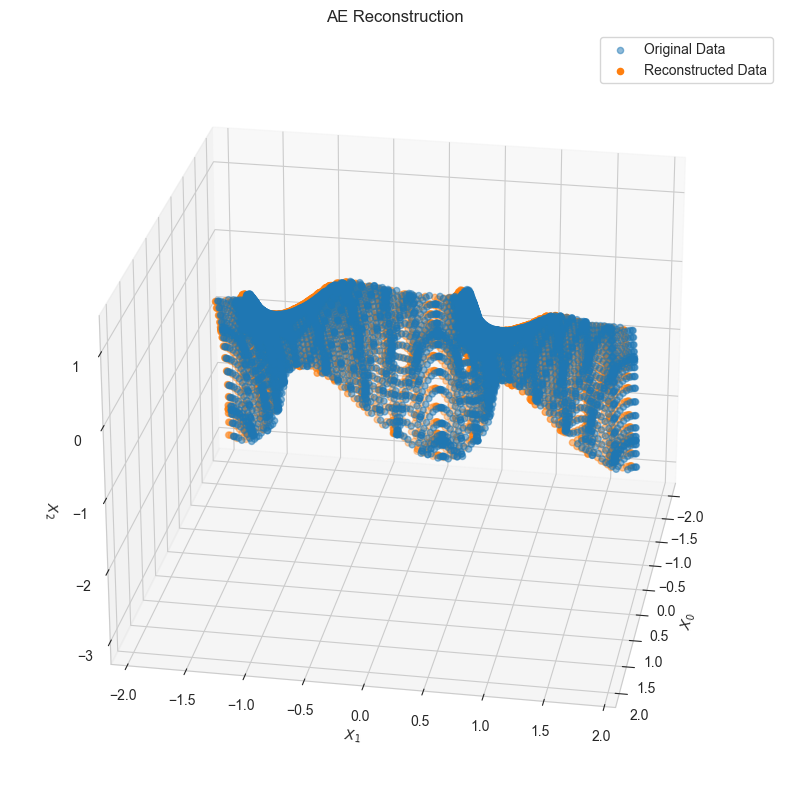

In [13]:


# Move data to GPU
X_torch = X_torch.to(device)
width = ambient_dim * 16
# Define models and move to GPU
encoder = MLP(ambient_dim, ambient_dim, [width] * 4).to(device)
decoder = SNMLP(ambient_dim, ambient_dim, [width] * 4).to(device)

opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

eta, l = 0.01, 0.01

for i in range(20000):
    opt.zero_grad()
    z = encoder(X_torch)
    rec_loss = F.mse_loss(decoder(z), X_torch)
    vol_loss = torch.exp(torch.log(z.std(0) + eta).mean())
    loss = rec_loss + l * vol_loss
    loss.backward()
    opt.step()

    if (i + 1) % 1000 == 0:
        print(f'Epoch {i+1:4}: rec = {rec_loss.item():.5g}, vol = {vol_loss.item():.5g}')

# Move data back to CPU for plotting
encoder.eval()
decoder.eval()
with torch.no_grad():
    X_P = decoder(encoder(X_torch)).cpu().numpy()

X_np = X_torch.cpu().numpy()

# Plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2], alpha=0.5)
ax.scatter(X_P[:, 0], X_P[:, 1], X_P[:, 2])
ax.set_xlabel('$X_0$')
ax.set_ylabel('$X_1$')
ax.set_zlabel('$X_2$')
ax.elev = 25
ax.azim = 10
plt.legend(['Original Data', 'Reconstructed Data'])
plt.title("AE Reconstruction")
plt.show()

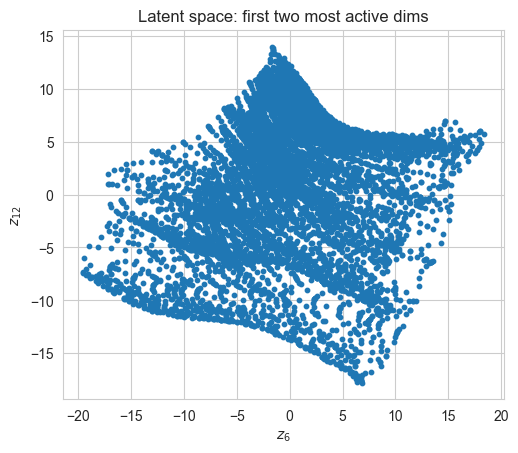

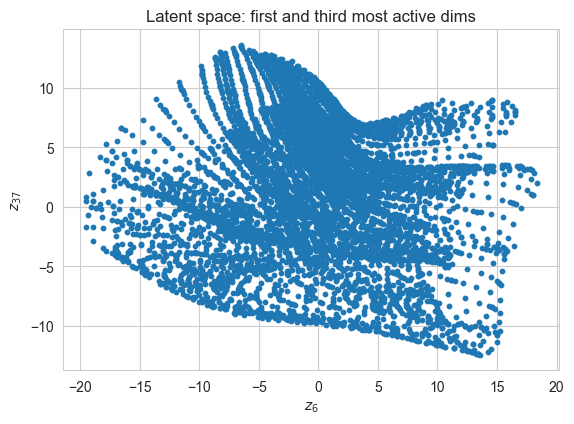

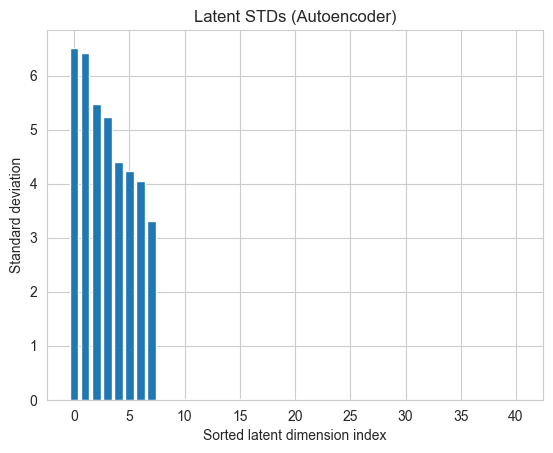

In [14]:
# Switch to eval mode and disable gradient tracking
encoder.eval()
decoder.eval()
with torch.no_grad():
    z = encoder(X_torch)

# Move latent vectors to CPU once and convert to NumPy
z_np = z.detach().cpu().numpy()

# Rank dimensions by standard deviation (importance)
idx = z.std(0).argsort(descending=True)

# ---- Plot 1: z0 vs z1 ----
plt.figure()
plt.scatter(z_np[:, idx[0]], z_np[:, idx[1]], s=10)
plt.gca().set_aspect('equal')
plt.xlabel(f'$z_{{{idx[0]}}}$')
plt.ylabel(f'$z_{{{idx[1]}}}$')
plt.title('Latent space: first two most active dims')
plt.show()

# ---- Plot 2: z0 vs z2 ----
plt.figure()
plt.scatter(z_np[:, idx[0]], z_np[:, idx[2]], s=10)
plt.gca().set_aspect('equal')
plt.xlabel(f'$z_{{{idx[0]}}}$')
plt.ylabel(f'$z_{{{idx[2]}}}$')
plt.title('Latent space: first and third most active dims')
plt.show()

# Compute and sort latent STDs
z_std = z.std(0).detach().cpu().numpy()
idx = z.std(0).detach().cpu().argsort(descending=True)

# Plot
plt.figure()
plt.bar(np.arange(len(z_std)), z_std[idx])
plt.title('Latent STDs (Autoencoder)')
plt.xlabel('Sorted latent dimension index')
plt.ylabel('Standard deviation')
plt.show()



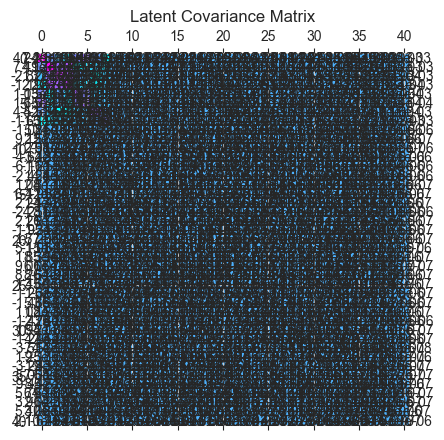

In [15]:
cov = z.T[idx].cov().detach().cpu().numpy()
plt.matshow(cov, cmap='cool')
for (i, j), var in np.ndenumerate(cov):
    plt.gca().text(j, i, '{:.2e}'.format(var), ha='center', va='center')
plt.title('Latent Covariance Matrix')
plt.show()

In [16]:
# df_GLV = pd.DataFrame(z.cpu().detach().numpy(), columns=[f'z{i}' for i in range(z.shape[1])])
# plt.figure()
# sns.pairplot(df)
# plt.suptitle('Latent Space Pairplot', y=1.02)
# plt.show()